In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def read_sample_data():
    return pd.read_csv('sample_traffic_data.csv', index_col=False)

    
def draw_sample_bitrate_over_time(source_node = -1, destination_node = -1, figsize=(15, 5), constant_bitrate=-1, savefig=False):
    """
    draws sample bitrate file for a chosen pair of nodes, use -1 for no filtering; 
    use constant_bitrate to alter bitrates of all requests to a chosen value, -1 for original bitrates
    """
    sample_data = read_sample_data()
    if(constant_bitrate != -1):
        sample_data['datarate'] = constant_bitrate
    if(source_node == -1 and destination_node == -1):
        datarates = sample_data['datarate']
        start_times = sample_data['arrival_time']
        end_times = sample_data['departure_time']
    elif(source_node == -1):
        datarates = sample_data.loc[sample_data['destination_id'] == destination_node]['datarate']
        start_times = sample_data.loc[sample_data['destination_id'] == destination_node]['arrival_time']
        end_times = sample_data.loc[sample_data['destination_id'] == destination_node]['departure_time']
    elif(destination_node == -1):
        datarates = sample_data.loc[sample_data['source_id'] == source_node]['datarate']
        start_times = sample_data.loc[sample_data['source_id'] == source_node]['arrival_time']
        end_times = sample_data.loc[sample_data['source_id'] == source_node]['departure_time']
    else:
        datarates = sample_data.loc[(sample_data['source_id'] == source_node) & (sample_data['destination_id'] == destination_node)]['datarate']
        start_times = sample_data.loc[(sample_data['source_id'] == source_node) & (sample_data['destination_id'] == destination_node)]['arrival_time']
        end_times = sample_data.loc[(sample_data['source_id'] == source_node) & (sample_data['destination_id'] == destination_node)]['departure_time']

    if(datarates.empty):
        print('wrong source or destination node')
    else:    
        test = pd.DataFrame([datarates,start_times,end_times]).transpose()
        values = list(test.itertuples(index=False, name=None))

        sorted_values = sorted(values, key=lambda x: (x[1], x[2]))
        time_points = []
        sums = []
        values = []
        current_sum = 0
        end_times = []
        for value, start_time, end_time in sorted_values:
            time_points.append(start_time)
            values.append(value)
            time_points.append(end_time)
            values.append(-value)

        time_points, values = zip(*sorted(zip(time_points, values)))

        for i in range(len(time_points)):
            current_sum +=values[i]
            sums.append(current_sum)

        plt.figure(figsize=figsize)
        plt.step(time_points, sums)
        plt.xlabel('day')
        plt.ylabel('bitrate')
        plt.xticks(np.arange(0,31))
        if(source_node == -1):
            source_node = 'all'
        if(destination_node == -1):
            destination_node = 'all' 
        if(constant_bitrate != -1):
            plt.title('bitrate over time, from {} to {}, altered to constant bitrate of {}'.format(source_node, destination_node, constant_bitrate))
        else:           
            plt.title('bitrate over time, from {} to {}'.format(source_node, destination_node))
        plt.tight_layout()
        if(savefig):
            if(constant_bitrate == -1):
                constant_bitrate = ''
            plt.savefig('mean_bitrate{}.jpeg'.format(constant_bitrate), dpi=600)
        plt.show()


def draw_sample_data_duration_histogram(nbins=200, figsize=(10,5), savefig=False):
    sample_data = read_sample_data()
    sample_data['duration'] = sample_data['departure_time'] - sample_data['arrival_time']

    plt.figure(figsize=figsize)
    plt.hist(sample_data['duration'], bins=nbins)
    plt.title('request duration histogram')
    plt.xlabel('request duration in days')
    plt.ylabel('request count')
    plt.tight_layout()
    if(savefig):
        plt.savefig('duration_histogram.jpeg',dpi=600)
    plt.show()


def draw_request_count_over_time(source_node = -1, destination_node = -1, figsize=(15, 5), savefig=False):
    """
    draws request count for a chosen pair of nodes, use -1 for no filtering
    """
    sample_data = read_sample_data()
    if(source_node != -1 and destination_node != -1):
        sample_data = sample_data.loc[(sample_data['source_id'] == source_node) & (sample_data['destination_id'] == destination_node)]
    elif(source_node == -1 and destination_node != -1):
        sample_data = sample_data.loc[sample_data['destination_id'] == destination_node]
    elif(destination_node == -1 and source_node != -1):
        sample_data = sample_data.loc[sample_data['source_id'] == source_node]

    sample_data = sample_data.to_dict('records')

    time_periods = [(i, i + 1) for i in range(35)]  

    requests_sum_list = []

    for start, end in time_periods:
        request_count = sum(start <= request['arrival_time'] < end or start <= request['departure_time'] < end for request in sample_data)
        requests_sum_list.append(request_count)

    plt.figure(figsize=figsize)
    plt.step(np.arange(0,35),pd.Series(requests_sum_list))
    plt.xlabel('day')
    plt.ylabel('request count')
    if(source_node == -1):
        source_node = 'all'
    if(destination_node == -1):
        destination_node = 'all' 
    plt.title('request count over time, from {} to {}'.format(source_node, destination_node))
    plt.tight_layout()
    if(savefig):
        plt.savefig('request_count.jpeg', dpi=600)
    plt.show()


def read_seattle_data(aggregation='avg'):
    """
    reads the files with Seattle data; 
    aggregation types: 'avg' and 'max'
    """
    if(aggregation == 'avg'):
        six_daily_avg = pd.read_csv('agg_avg_daily.txt', sep='\t')
        six_daily_avg = six_daily_avg.drop(columns='Epoch Seconds')
        six_daily_avg = six_daily_avg.rename(columns={"YYYY-MM-DD UTC": "date", "Average aggregate bits per second": "bitrate"})
        six_daily_avg = six_daily_avg.set_index('date')
        six_daily_avg.index = pd.to_datetime(six_daily_avg.index)
        six_daily_avg = six_daily_avg.asfreq('d')
        return six_daily_avg

    if(aggregation == 'max'):
        six_daily_max = pd.read_csv('agg_max_daily.txt', sep='\t')
        six_daily_max = six_daily_max.drop(columns='Epoch Seconds')
        six_daily_max = six_daily_max.rename(columns={"YYYY-MM-DD UTC": "date", "Maximum aggregate bits per second": "bitrate"})
        six_daily_max = six_daily_max.set_index('date')
        six_daily_max.index = pd.to_datetime(six_daily_max.index)
        six_daily_max = six_daily_max.asfreq('d')
        return six_daily_max
    
    else:
        print('unknown aggregation')
        return pd.DataFrame([])


def draw_seattle_year_month_by_month(year=2022, aggregation='max', figsize=(18,6), savefig=False):
    """
    draws Seattle data month by month for a chosen year and aggregation type, with reset indexes; 
    aggregation types: 'avg' and 'max'
    """
    datasource = read_seattle_data(aggregation)
    year=year
    
    if(datasource.empty != True):
        plt.figure(figsize=figsize)
        plt.plot(datasource['{}-01-01'.format(year):'{}-01-31'.format(year)].reset_index(drop=True), label='jan', linestyle='solid',  color='navy')
        plt.plot(datasource['{}-02-01'.format(year):'{}-02-28'.format(year)].reset_index(drop=True), label='feb', linestyle='dashed',  color='dodgerblue')
        plt.plot(datasource['{}-03-01'.format(year):'{}-03-31'.format(year)].reset_index(drop=True), label='mar', linestyle='solid',  color='mediumturquoise')
        plt.plot(datasource['{}-04-01'.format(year):'{}-04-30'.format(year)].reset_index(drop=True), label='apr', linestyle='dashed',  color='yellowgreen')
        plt.plot(datasource['{}-05-01'.format(year):'{}-05-31'.format(year)].reset_index(drop=True), label='may', linestyle='solid',  color='forestgreen')
        plt.plot(datasource['{}-06-01'.format(year):'{}-06-30'.format(year)].reset_index(drop=True), label='jun', linestyle='dashed',  color='gold')
        plt.plot(datasource['{}-07-01'.format(year):'{}-07-31'.format(year)].reset_index(drop=True), label='jul', linestyle='solid',  color='darkorange')
        plt.plot(datasource['{}-08-01'.format(year):'{}-08-31'.format(year)].reset_index(drop=True), label='aug', linestyle='dashed',  color='darkgoldenrod')
        plt.plot(datasource['{}-09-01'.format(year):'{}-09-30'.format(year)].reset_index(drop=True), label='sep', linestyle='solid',  color='chocolate')
        plt.plot(datasource['{}-10-01'.format(year):'{}-10-31'.format(year)].reset_index(drop=True), label='oct', linestyle='dashed',  color='firebrick')
        plt.plot(datasource['{}-11-01'.format(year):'{}-11-30'.format(year)].reset_index(drop=True), label='nov', linestyle='solid',  color='maroon')
        plt.plot(datasource['{}-12-01'.format(year):'{}-12-31'.format(year)].reset_index(drop=True), label='dec', linestyle='dashed',  color='dimgray')
        plt.xlabel('day of the month')
        plt.ylabel('bitrate')
        plt.legend()
        plt.title('Seattle {}, {}'.format(year,aggregation))
        plt.tight_layout()
        if(savefig):
            plt.savefig('seattle_month_by_month_{}_{}.jpeg'.format(year,aggregation), dpi=600)
        plt.show()   


def draw_seattle_avg_and_max(from_date=0, ylog=True, figsize=(15,7), resampling='no', savefig=False):
    """
    draws Seatlle traffic from specified date formatted as 'yyyy-mm-dd' (or from the beginning if 0);
    aggregation types: 'avg' and 'max', ylog: use logaritmic yaxis, optional resampling: 'weekly' and 'monthly'
    """
    six_daily_avg = read_seattle_data('avg')
    six_daily_max = read_seattle_data('max')
    if(resampling == 'weekly'):
        six_daily_avg = six_daily_avg.resample('7d').mean()
        six_daily_max = six_daily_max.resample('7d').mean()
    elif(resampling == 'monthly'):
        six_daily_avg = six_daily_avg.resample('M').mean()
        six_daily_max = six_daily_max.resample('M').mean()   
    else:
        resampling = 'no'              
    from_date = from_date
    plt.figure(figsize=figsize)
    plt.plot(six_daily_max[from_date:], label='max', color='teal')
    plt.plot(six_daily_avg[from_date:], label='avg', color='darkmagenta')
    plt.xlabel('time')
    plt.ylabel('bitrate')
    plt.legend()
    if(ylog):
        plt.yscale('log')
    if(resampling == 'no'):    
        plt.title('Seattle daily bitrate over time')
    else:
        plt.title('Seattle bitrate over time, {} resampling'.format(resampling))
    plt.tight_layout()
    if(savefig):
        plt.savefig('seattle_avg_and_max_{}_resampling.jpeg'.format(resampling), dpi=600)
    plt.show()   


def draw_seattle_year_by_year(aggregation='avg', year_from=2018, year_to=2022, ylog=False, figsize=(18,6), resampling='no', savefig=False):
    """
    draws Seatlle traffic for the chosen year range with reset indexes;
    aggregation types: 'avg' and 'max', ylog: use logaritmic yaxis, optional resampling: 'weekly' and 'monthly'
    """
    if(aggregation != 'avg' and aggregation != 'max'):
        print('unknown aggregation')
    else:    
        plt.figure(figsize=figsize)
        six_daily_avg = read_seattle_data(aggregation)
        if(resampling == 'weekly'):
            six_daily_avg = six_daily_avg.resample('7d').mean()
        elif(resampling == 'monthly'):
            six_daily_avg = six_daily_avg.resample('M').mean()
        else:
            resampling = 'no'    

        years=np.arange(year_to,year_from-1, -1)
        for year in years:    
            plt.plot(six_daily_avg['{}-01-01'.format(year):'{}-12-31'.format(year)].reset_index(drop=True), label='{}'.format(year))

        plt.xlabel('Time')
        plt.ylabel('Bitrate')
        plt.legend()
        if(ylog):
            plt.yscale('log')
        if(resampling == 'no'):    
            plt.title('Seattle daily bitrate over time, {}'.format(aggregation))
        else:
            plt.title('Seattle bitrate over time, {}, {} resampling'.format(aggregation,resampling))
        plt.tight_layout()
        if(savefig):
            plt.savefig('seattle_year_by_year_{}_resampling.jpeg'.format(resampling), dpi=600)
        plt.show()


def draw_seattle_cumsums(aggregation='avg', year_from=2018, year_to=2022, figsize=(18,6), savefig=False):
    """
    draws cumsums for the chosen year range with reset indexes; 
    aggregation types: 'avg' and 'max'
    """
    if(aggregation != 'avg' and aggregation != 'max'):
        print('unknown aggregation')
    else:    
        plt.figure(figsize=figsize)
        
        six_daily_avg = read_seattle_data(aggregation)
        
        years=np.arange(year_to,year_from-1, -1)
        for year in years:
            plt.plot(six_daily_avg['{}-01-01'.format(year):'{}-12-31'.format(year)].reset_index(drop=True).cumsum(), label='{}'.format(year))

        plt.xlabel('Time')
        plt.ylabel('Bitrate')
        plt.legend()
        plt.title('Seattle cumsums, {}'.format(aggregation))
        plt.tight_layout()
        if(savefig):
            plt.savefig('seattle_cumsums_{}.jpeg'.format(aggregation), dpi=600)
        plt.show()


def draw_seattle_percentage_yearly(aggregation='avg', year_from=2018, year_to=2022, figsize=(18,6), savefig=False):
    seattle_avg = read_seattle_data(aggregation)
    years=np.arange(year_from,year_to+1)
    plt.figure(figsize=figsize)
    for year in years:
        seattle_list = seattle_avg['{}-01-01'.format(year):'{}-12-31'.format(year)]['bitrate']
        first_value = seattle_list[0]
        percentages = (seattle_list / first_value) * 100
        percentages = percentages.reset_index(drop=True)
        plt.plot(percentages, label=year)
    plt.title('Seattle yearly traffic (daily {}) as a percentage of Jan 1st'.format(aggregation))
    plt.ylabel('percentage of Jan 1st')
    plt.xlabel('day of the year')
    plt.legend()
    plt.tight_layout()
    if(savefig):
        plt.savefig('seattle_percentage_yearly_{}_{}_{}.jpeg'.format(aggregation,year_from,year_to), dpi=600)
    plt.show()         
 

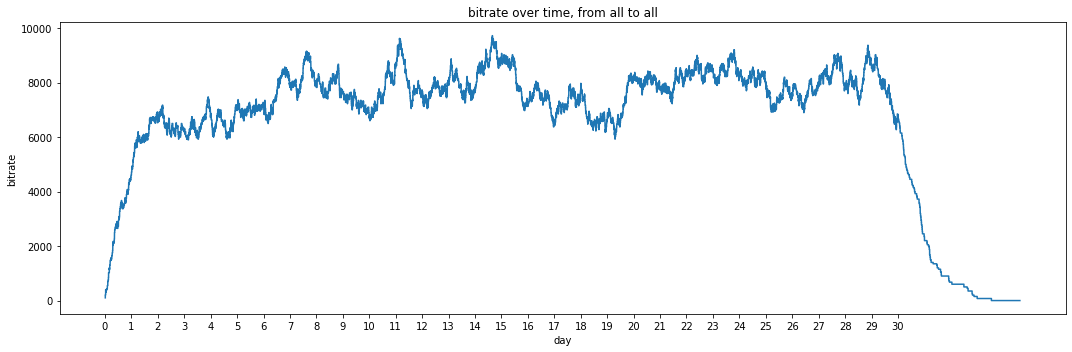

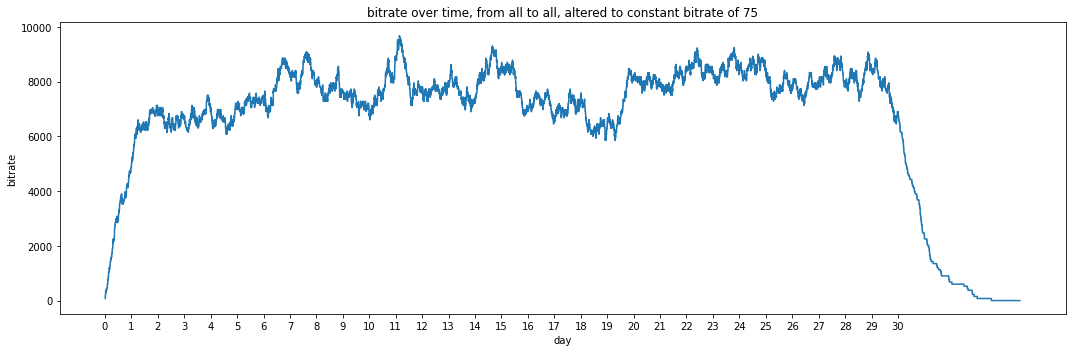

In [3]:
draw_sample_bitrate_over_time(source_node=-1, destination_node=-1, savefig=True)
draw_sample_bitrate_over_time(source_node=-1, destination_node=-1, constant_bitrate=75, savefig=True)

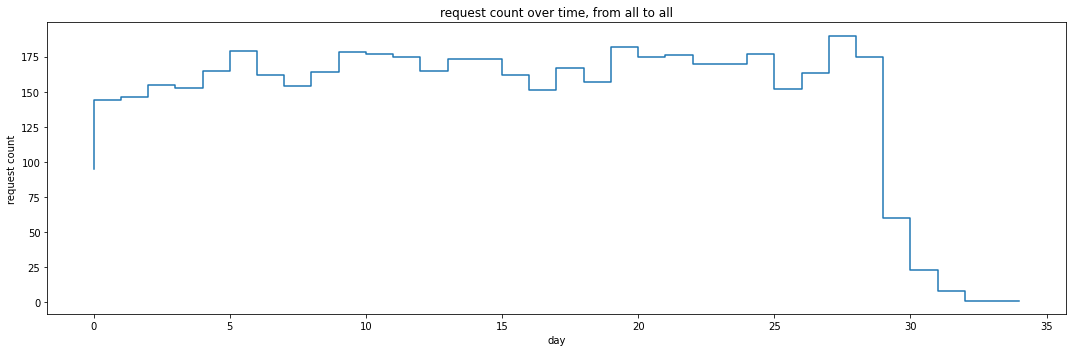

In [4]:
draw_request_count_over_time(-1,-1, savefig=True)

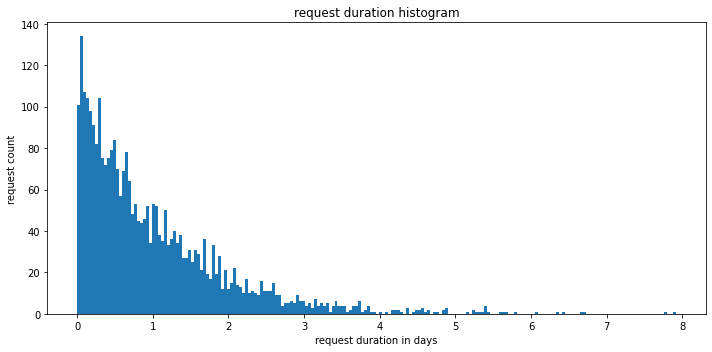

In [5]:
draw_sample_data_duration_histogram(nbins=200, savefig=True)

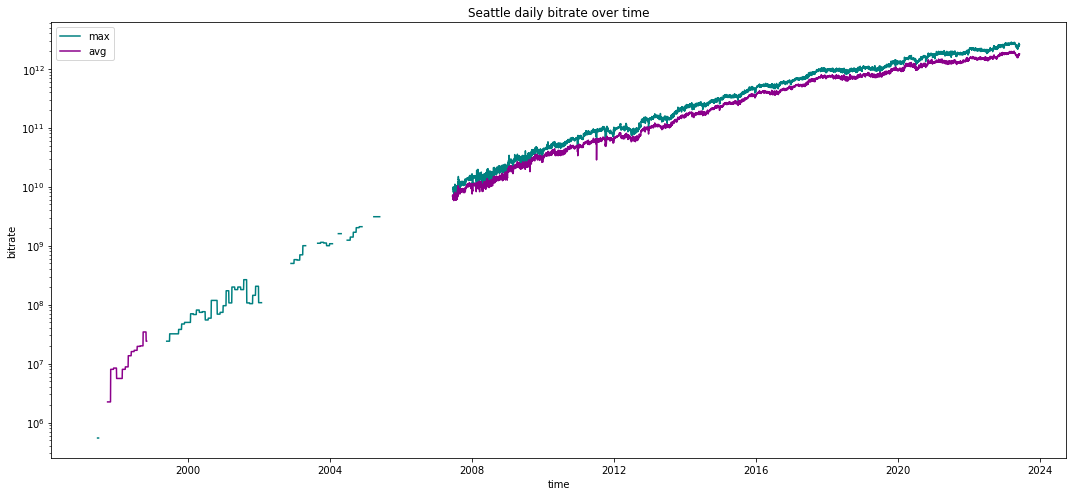

In [6]:
draw_seattle_avg_and_max(from_date=0,ylog=True)

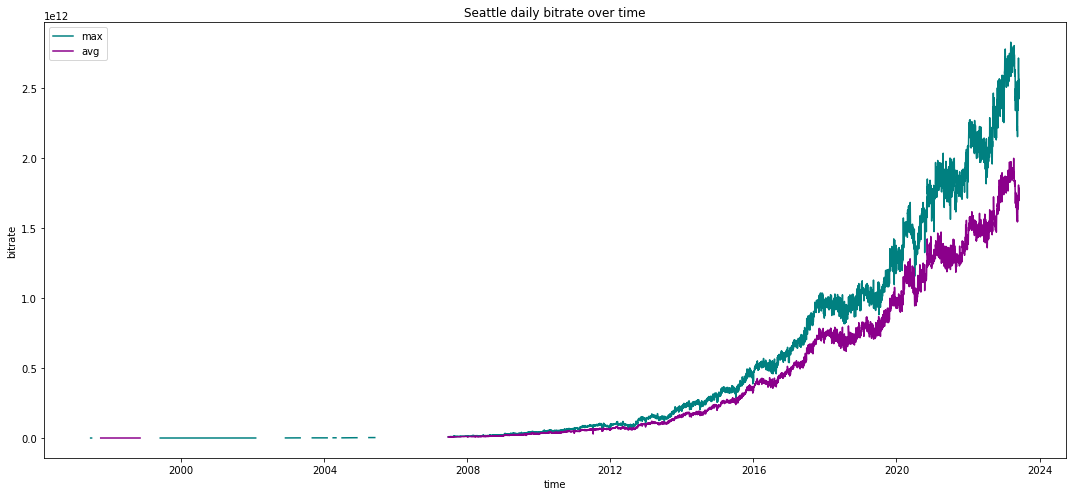

In [7]:
draw_seattle_avg_and_max(from_date=0,ylog=False)

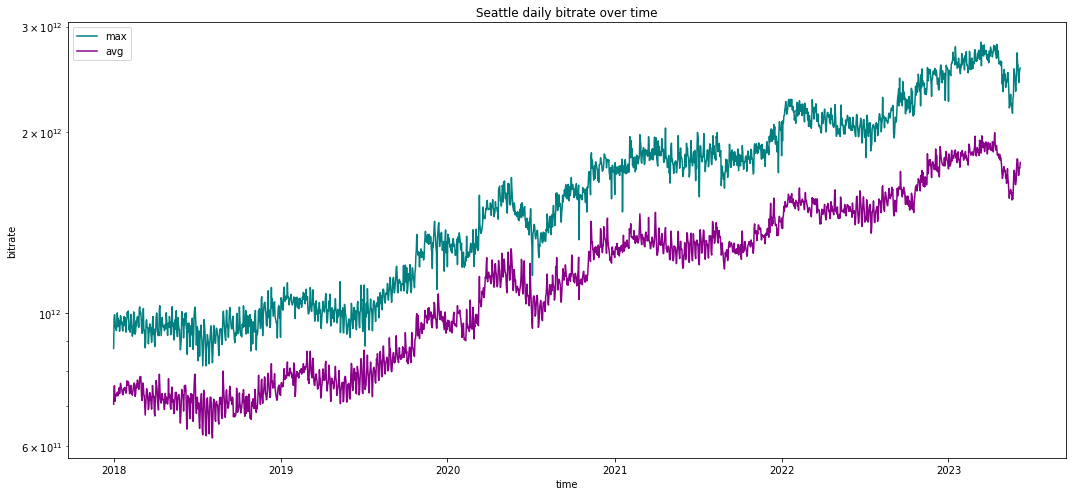

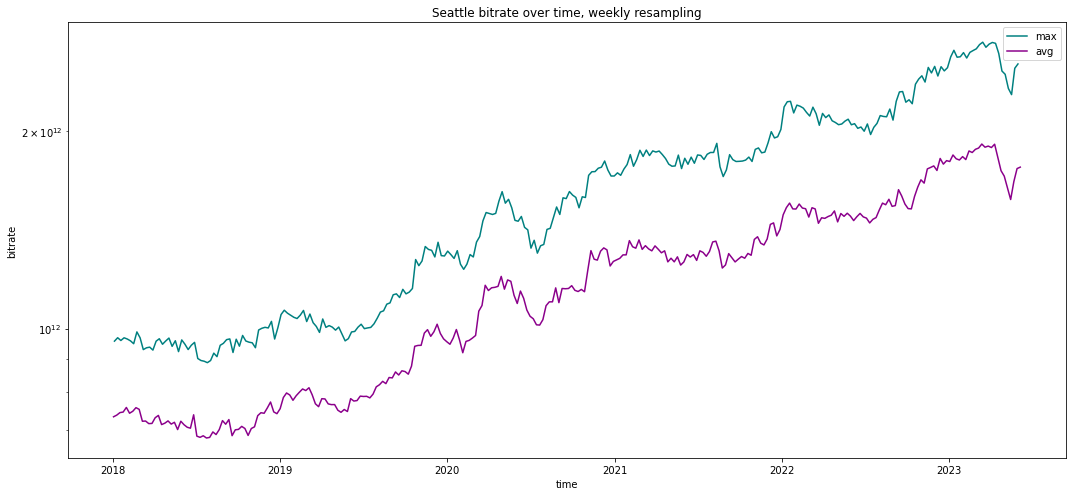

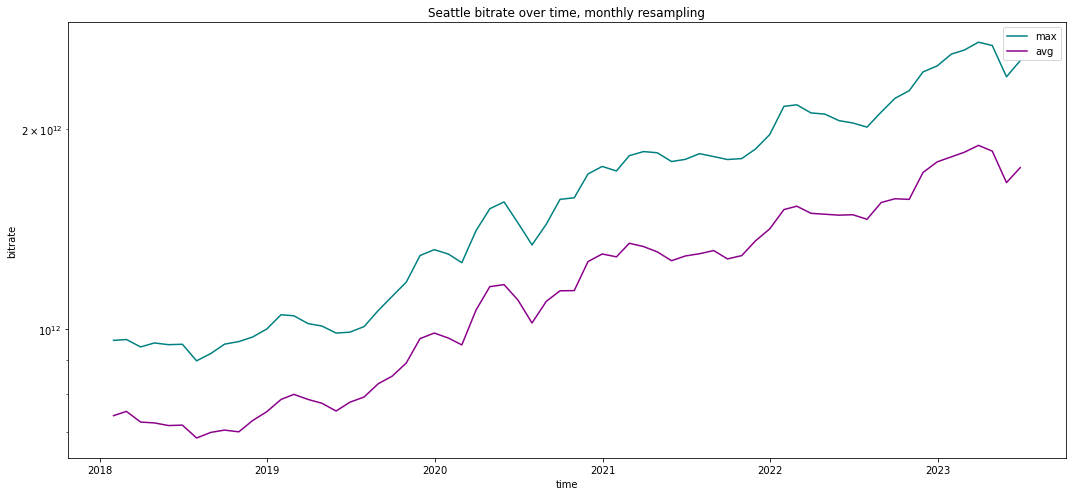

In [8]:
draw_seattle_avg_and_max(from_date='2018-01-01',ylog=True, savefig=True)
draw_seattle_avg_and_max(from_date='2018-01-01',ylog=True,resampling='weekly', savefig=True)
draw_seattle_avg_and_max(from_date='2018-01-01',ylog=True,resampling='monthly', savefig=True)

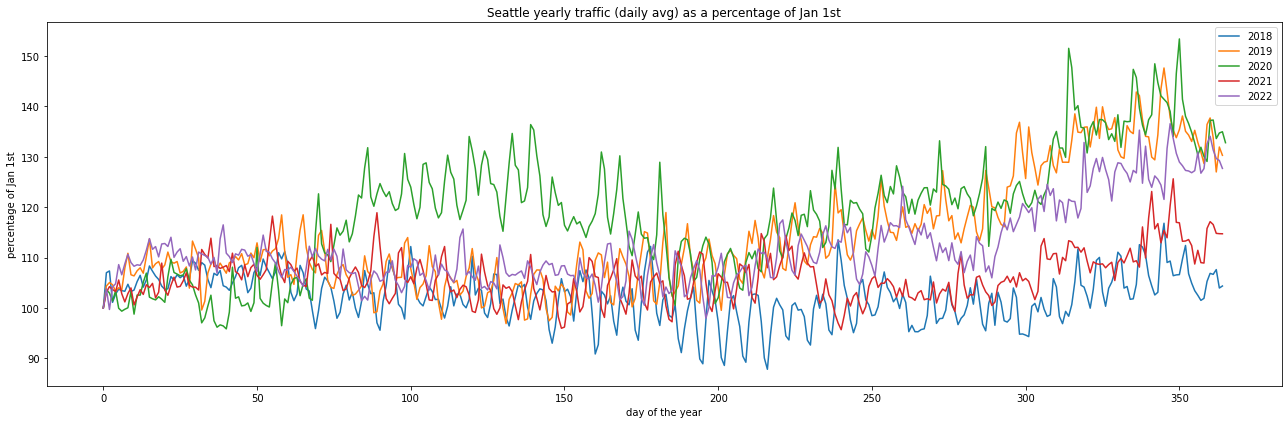

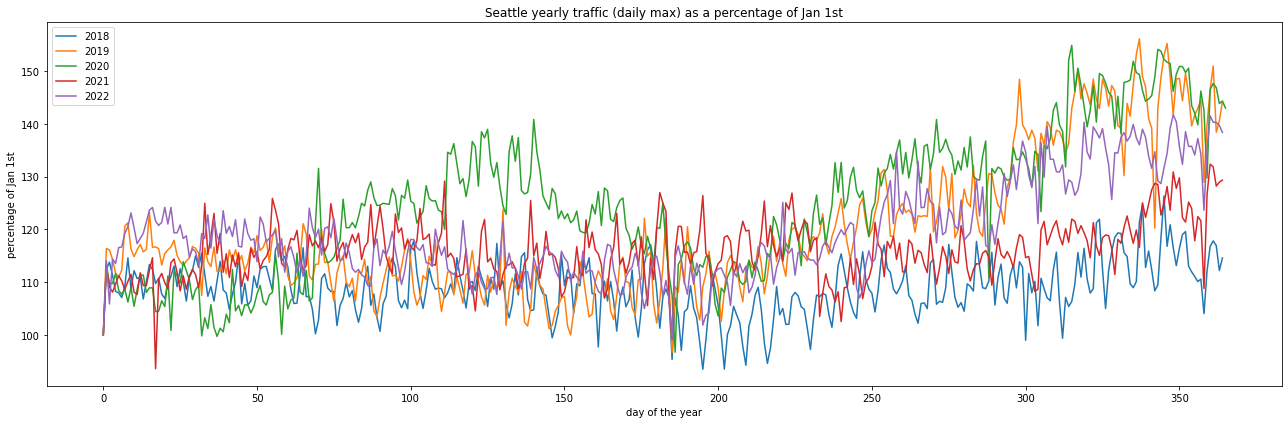

In [9]:
draw_seattle_percentage_yearly(aggregation='avg', year_from=2018, year_to=2022, savefig=True)
draw_seattle_percentage_yearly(aggregation='max', year_from=2018, year_to=2022, savefig=True)

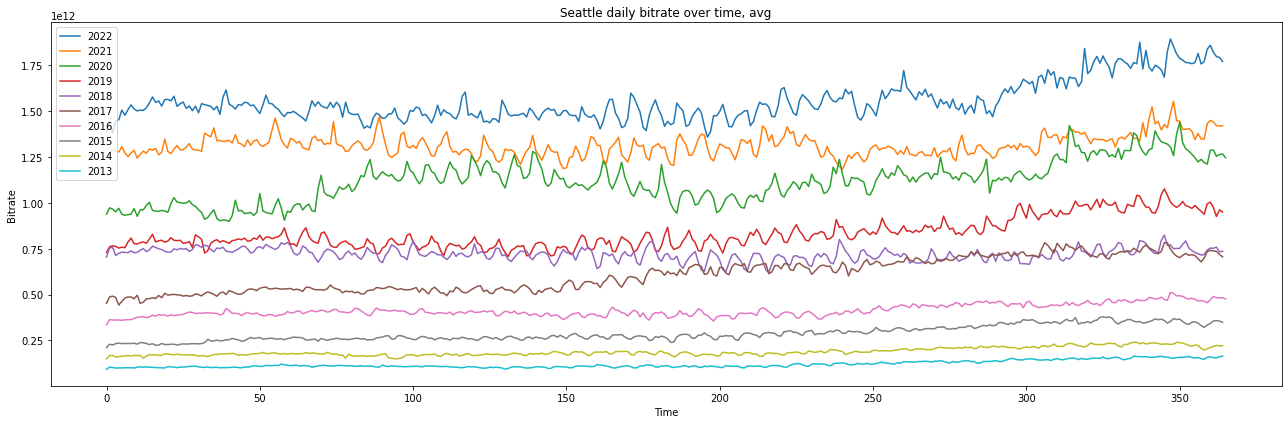

In [10]:
draw_seattle_year_by_year(aggregation='avg', year_from=2013, year_to=2022)

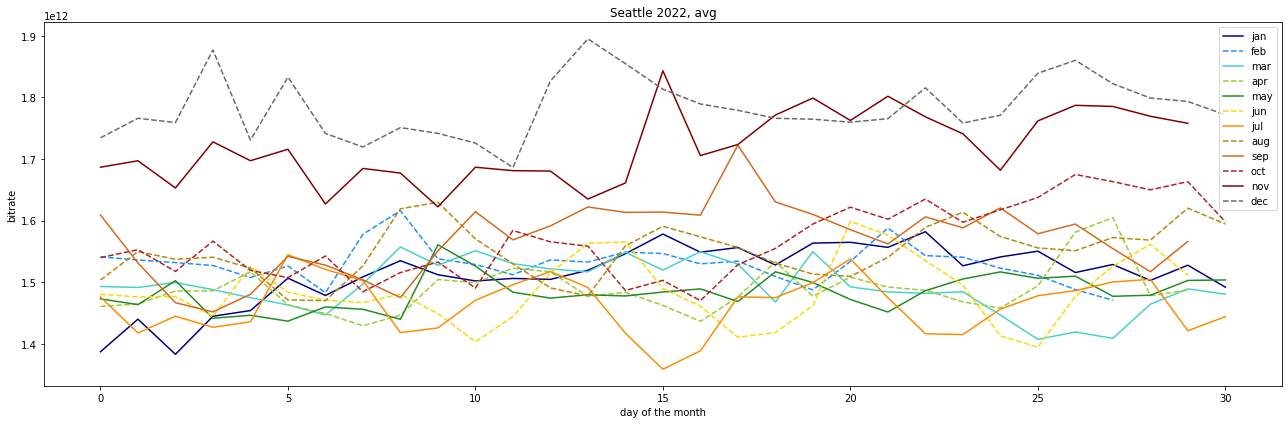

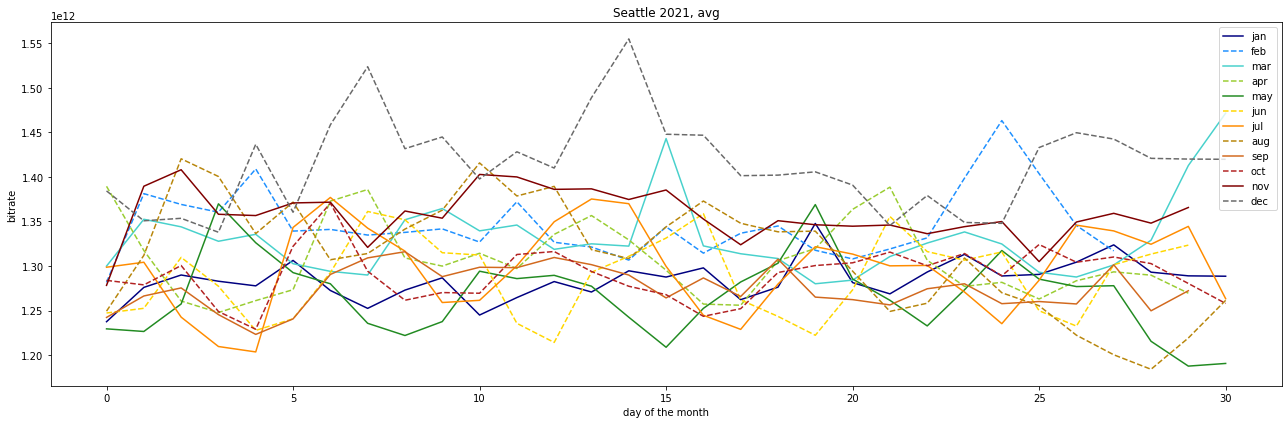

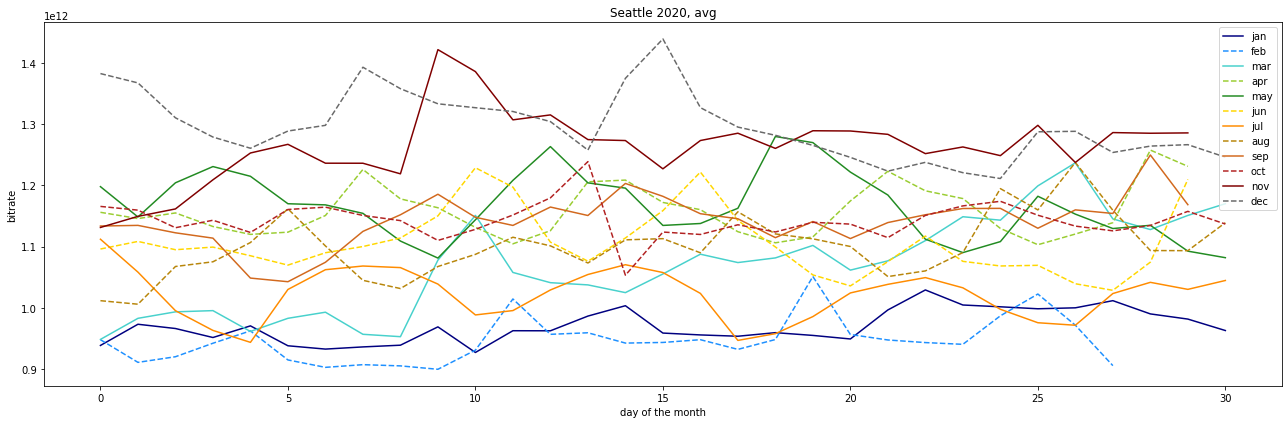

In [11]:
draw_seattle_year_month_by_month(year=2022,aggregation='avg')
draw_seattle_year_month_by_month(year=2021,aggregation='avg')
draw_seattle_year_month_by_month(year=2020,aggregation='avg')

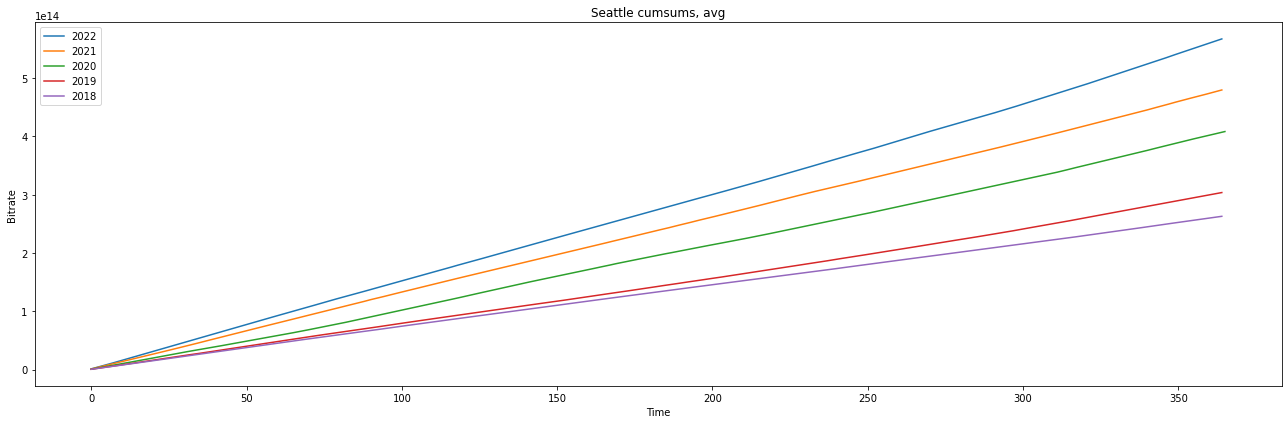

In [12]:
draw_seattle_cumsums(aggregation='avg')

<AxesSubplot:xlabel='date'>

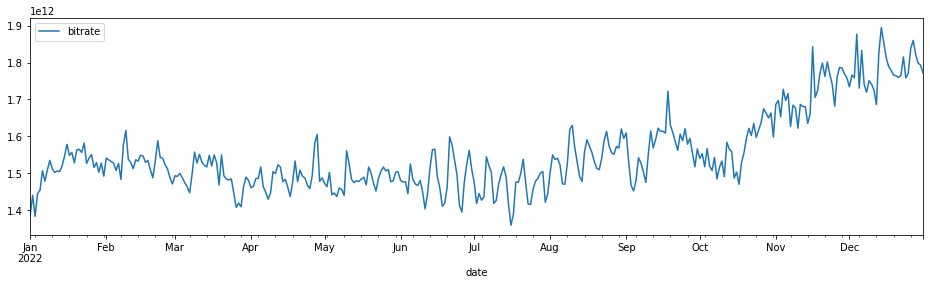

In [13]:
seattle_avg = read_seattle_data('avg')
seattle_avg = seattle_avg['2022-01-01':'2022-12-31']
seattle_avg.plot(figsize=(16,4))

<AxesSubplot:xlabel='date'>

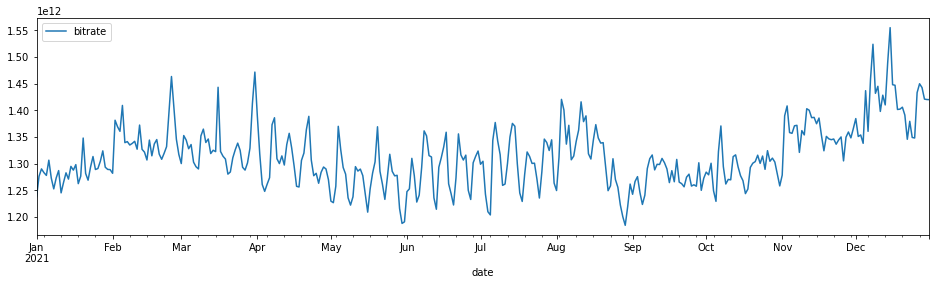

In [14]:
seattle_avg = read_seattle_data('avg')
seattle_avg = seattle_avg['2021-01-01':'2021-12-31']
seattle_avg.plot(figsize=(16,4))

<AxesSubplot:xlabel='date'>

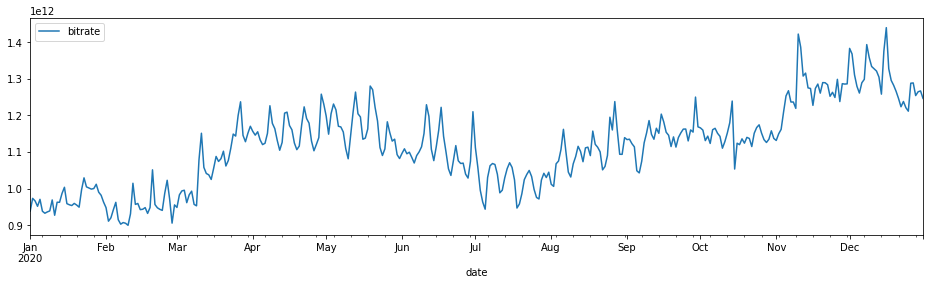

In [15]:
seattle_avg = read_seattle_data('avg')
seattle_avg = seattle_avg['2020-01-01':'2020-12-31']
seattle_avg.plot(figsize=(16,4))